#HYPERPARAMETER OPTIMIZATION WITH GRID SEARCH

I tested different hyperparameters and based on my results, it seems that the Adam optimizer did significantly better than Stochastic Gradient Descent. Additionally, it seems like a dropout value of 0.05 was better than a dropout value of 0.10 with the Adam optimizer. The best result had a spearman score of ~0.85 which is very strong for the task I was finetuning the transformer on, which is predicting emotional arousal scores from narrative stories.

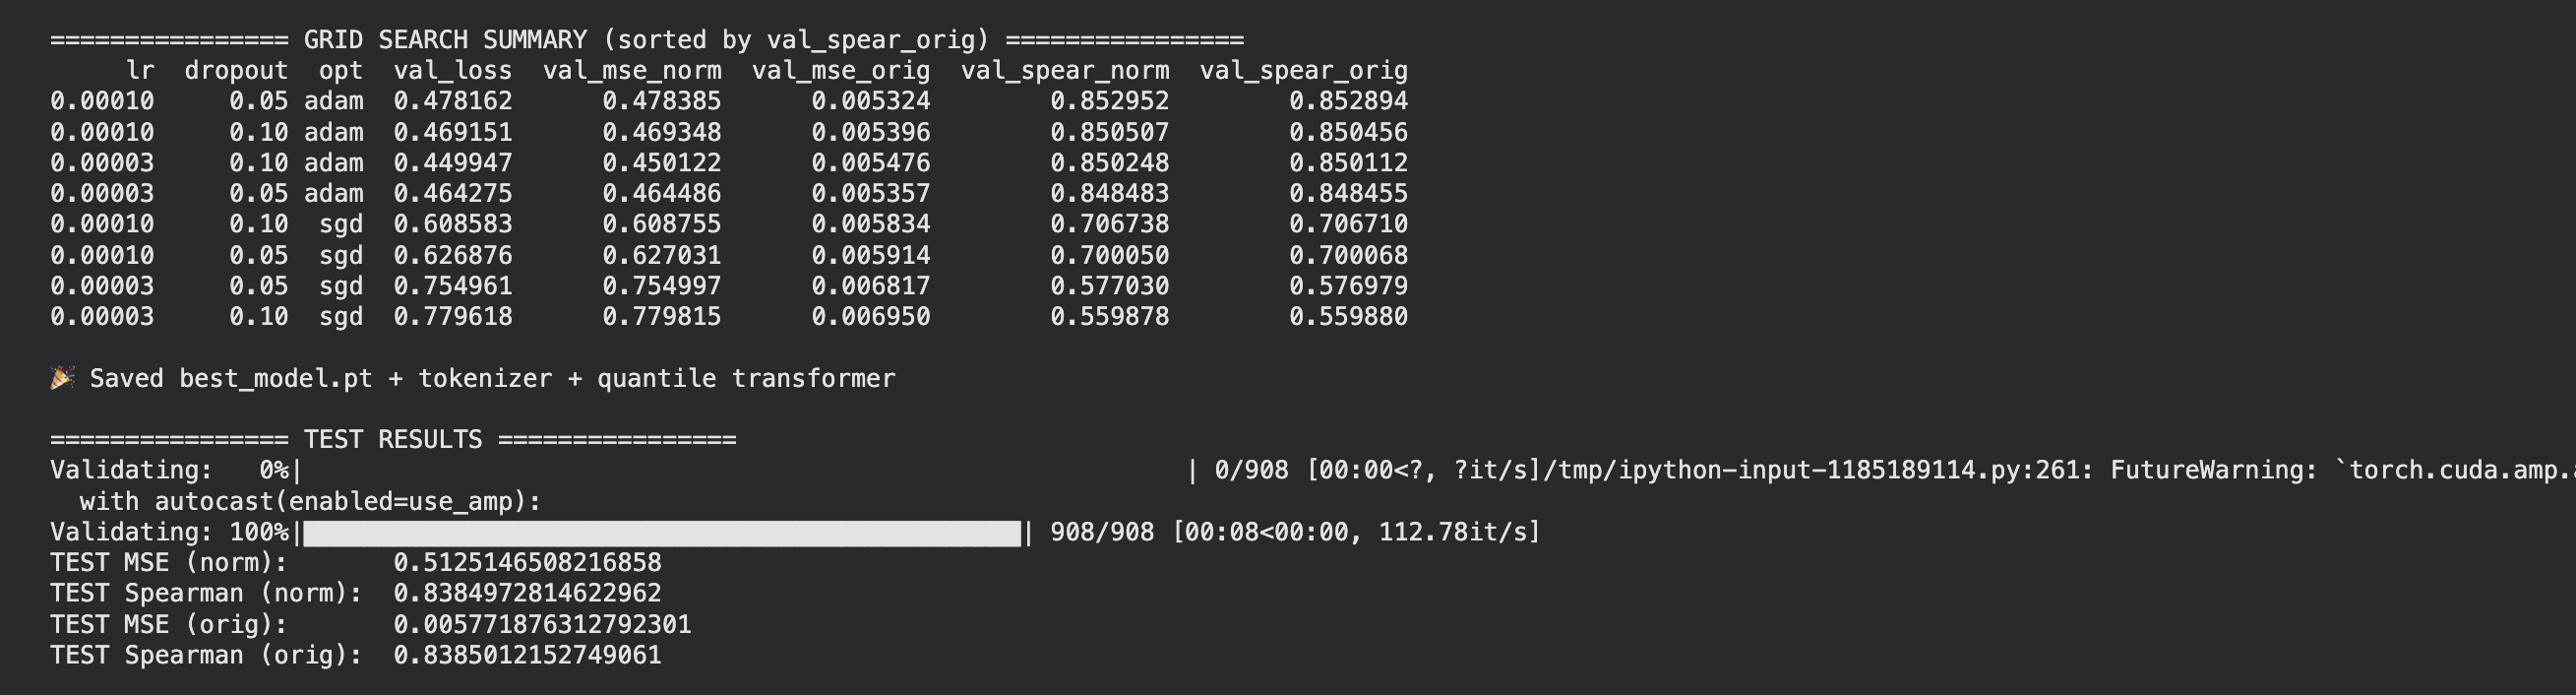

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from tqdm import tqdm
import random
import nltk
import joblib
from torch.cuda.amp import autocast  # <-- AMP for CUDA
from itertools import product

nltk.download("wordnet")
from nltk.corpus import wordnet  # noqa: F401 (placeholder for future augmentation)

# ============================================================
# DEVICE & AMP SETUP  (FORCE CUDA)
# ============================================================
if not torch.cuda.is_available():
    raise SystemError("CUDA is not available. Please enable a GPU runtime (e.g., Colab: Runtime → Change runtime type → GPU).")

device = "cuda"
print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)
print("GPU:", torch.cuda.get_device_name(0))
torch.backends.cudnn.benchmark = True
use_amp = True  # mixed precision on GPU

# ============================================================
# SPLIT CR4 INTO TRAIN / VAL / TEST (80/10/10)
# ============================================================
from sklearn.model_selection import train_test_split

cr4_full = pd.read_csv("data/cr4/CR4NarrEmote_t1Yes.csv", low_memory=False)
cr4_full = cr4_full.rename(columns={"passage": "text", "EMO_arousal": "arousal"})[["text", "arousal"]]
cr4_full["arousal"] = pd.to_numeric(cr4_full["arousal"], errors="coerce")
cr4_full = cr4_full.dropna()

# 80% train, 20% temp
cr4_train, cr4_temp = train_test_split(
    cr4_full,
    test_size=0.20,
    random_state=42,
    shuffle=True,
)

# split remaining 20% into 10% val, 10% test
cr4_val, cr4_test = train_test_split(
    cr4_temp,
    test_size=0.50,
    random_state=42,
    shuffle=True,
)

# ============================================================
# LOAD TALES_VA AND RESPLIT TO 80/10/10
# ============================================================
aem_train_raw = pd.read_csv("data/tales_va/train.csv")[["text", "A_EWE"]]
aem_val_raw = pd.read_csv("data/tales_va/val.csv")[["text", "A_EWE"]]
aem_test_raw = pd.read_csv("data/tales_va/test.csv")[["text", "A_EWE"]]

aem_full = pd.concat([aem_train_raw, aem_val_raw, aem_test_raw], ignore_index=True)
aem_full = aem_full.rename(columns={"A_EWE": "arousal"})
aem_full["arousal"] = pd.to_numeric(aem_full["arousal"], errors="coerce")
aem_full = aem_full.dropna()

train_aem, temp_aem = train_test_split(
    aem_full,
    test_size=0.20,
    random_state=42,
    shuffle=True,
)
val_aem, test_aem = train_test_split(
    temp_aem,
    test_size=0.50,
    random_state=42,
    shuffle=True,
)

# ============================================================
# COMBINE DATASETS WITHOUT DROPPING ANYTHING (OTHER THAN NaNs)
# ============================================================
train_aem["source"] = "aem"
val_aem["source"] = "aem"
test_aem["source"] = "aem"

cr4_train["source"] = "cr4"
cr4_val["source"] = "cr4"
cr4_test["source"] = "cr4"

train_df = pd.concat([train_aem, cr4_train], ignore_index=True)
val_df = pd.concat([val_aem, cr4_val], ignore_index=True)
test_df = pd.concat([test_aem, cr4_test], ignore_index=True)

print("Final dataset sizes (combined, no dropping):")
print(
    "TRAIN:", len(train_df),
    "| AEM:", (train_df["source"] == "aem").sum(),
    "| CR4:", (train_df["source"] == "cr4").sum(),
)
print(
    "VAL:  ", len(val_df),
    "| AEM:", (val_df["source"] == "aem").sum(),
    "| CR4:", (val_df["source"] == "cr4").sum(),
)
print(
    "TEST: ", len(test_df),
    "| AEM:", (test_df["source"] == "aem").sum(),
    "| CR4:", (test_df["source"] == "cr4").sum(),
)

# ============================================================
# NORMALIZE TARGETS (NO DATA LEAKAGE) - TO ~NORMAL
# ============================================================
print("Fitting quantile transformer (output_distribution='normal')...")
qt = QuantileTransformer(
    n_quantiles=200,
    output_distribution="normal",
    random_state=42,
)
qt.fit(train_df["arousal"].values.reshape(-1, 1))

train_df["arousal_norm"] = qt.transform(train_df["arousal"].values.reshape(-1, 1)).ravel()
val_df["arousal_norm"] = qt.transform(val_df["arousal"].values.reshape(-1, 1)).ravel()
test_df["arousal_norm"] = qt.transform(test_df["arousal"].values.reshape(-1, 1)).ravel()

# ============================================================
# AUGMENTATION (PLACEHOLDER)
# ============================================================
def augment(text: str, prob: float = 0.2) -> str:
    """
    Simple placeholder for text augmentation.
    Currently a no-op, but respects probability.
    """
    if prob <= 0.0:
        return text
    if random.random() > prob:
        return text
    # TODO: add actual augmentation (e.g., synonym replacement using wordnet)
    return text

# ============================================================
# DATASET + DATALOADERS
# ============================================================
MINILM_MODEL_NAME = "nreimers/MiniLM-L6-H384-uncased"

tokenizer = AutoTokenizer.from_pretrained(MINILM_MODEL_NAME)


class EmotionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, augment_prob: float = 0.2):
        self.df = df.reset_index(drop=True)
        self.augment_prob = augment_prob

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        text = augment(row["text"], prob=self.augment_prob)

        enc = tokenizer(
            text,
            truncation=True,
            max_length=256,
            padding="max_length",
            return_tensors="pt",
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(float(row["arousal_norm"]), dtype=torch.float32),
        }


# Weighted sampling for train set with ~75% CR4, 25% AEM
train_sources = train_df["source"].values
n_aem = (train_sources == "aem").sum()
n_cr4 = (train_sources == "cr4").sum()

target_frac_aem = 0.25
target_frac_cr4 = 0.75

weights = np.where(
    train_sources == "aem",
    target_frac_aem / n_aem,
    target_frac_cr4 / n_cr4,
)
weights = torch.DoubleTensor(weights)

train_sampler = WeightedRandomSampler(
    weights=weights,
    num_samples=len(weights),
    replacement=True,
)

train_dl = DataLoader(
    EmotionDataset(train_df, augment_prob=0.2),
    batch_size=16,
    sampler=train_sampler,
    num_workers=4,
    pin_memory=True,
)

val_dl = DataLoader(
    EmotionDataset(val_df, augment_prob=0.0),
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

test_dl = DataLoader(
    EmotionDataset(test_df, augment_prob=0.0),
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# ============================================================
# MODEL (MiniLM-based Regressor)
# ============================================================
class TransformerRegressor(nn.Module):
    def __init__(self, dropout: float = 0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MINILM_MODEL_NAME)
        self.dropout = nn.Dropout(dropout)
        self.reg_head = nn.Linear(self.encoder.config.hidden_size, 1)

    def forward(self, ids, mask):
        out = self.encoder(ids, attention_mask=mask)
        # Use CLS token representation (position 0)
        pooled = out.last_hidden_state[:, 0, :]
        pooled = self.dropout(pooled)
        return self.reg_head(pooled).view(-1)

# ============================================================
# EVALUATION FUNCTION (NORMAL + ORIGINAL SCALE)
# ============================================================
def evaluate(model: nn.Module, loader: DataLoader, qt: QuantileTransformer):
    model.eval()
    mse_loss = nn.MSELoss()

    batch_losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating", ncols=100):
            batch = {k: v.to(device) for k, v in batch.items()}

            with autocast(enabled=use_amp):
                out = model(batch["input_ids"], batch["attention_mask"])
                loss = mse_loss(out, batch["labels"])

            batch_losses.append(loss.item())
            all_preds.extend(out.detach().cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    preds = np.array(all_preds).reshape(-1, 1)
    labels = np.array(all_labels).reshape(-1, 1)

    # Normalized metrics (z-space)
    mse_norm = mean_squared_error(labels, preds)
    spear_norm = spearmanr(preds.ravel(), labels.ravel()).correlation

    # Back to original arousal scale
    preds_orig = qt.inverse_transform(preds).ravel()
    labels_orig = qt.inverse_transform(labels).ravel()

    mse_orig = mean_squared_error(labels_orig, preds_orig)
    spear_orig = spearmanr(preds_orig, labels_orig).correlation

    return {
        "avg_loss": float(np.mean(batch_losses)),
        "mse_norm": float(mse_norm),
        "spear_norm": float(spear_norm),
        "mse_orig": float(mse_orig),
        "spear_orig": float(spear_orig),
    }

# ============================================================
# TRAINING LOOP (with early stopping) + GRID-READY
# ============================================================
max_epochs = 5
patience_limit = 2

def train_model(hp):
    """
    Train a model with given hyperparams hp = {"lr": ..., "dropout": ..., "opt": ...}
    Uses validation Spearman (orig) for early stopping.
    Returns (ckpt_path, best_val_spear) for this run.
    """
    os.makedirs("checkpoints", exist_ok=True)

    model = TransformerRegressor(dropout=hp["dropout"]).to(device)

    # choose optimizer based on hp["opt"]
    if hp["opt"].lower() == "adam":
        optim = torch.optim.Adam(model.parameters(), lr=hp["lr"])
    elif hp["opt"].lower() == "sgd":
        optim = torch.optim.SGD(model.parameters(), lr=hp["lr"], momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {hp['opt']}")

    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.5)
    mse_loss = nn.MSELoss()

    best_val_spear = float("-inf")
    patience = 0
    ckpt_path = f"checkpoints/best_single_{hp['opt']}_lr{hp['lr']}_do{hp['dropout']}.pt"

    print("\n==============================")
    print("🔥 TRAINING MODEL:", hp)
    print("==============================")

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0.0

        for batch in tqdm(train_dl, desc=f"Epoch {epoch}", ncols=100):
            batch = {k: v.to(device) for k, v in batch.items()}

            with autocast(enabled=use_amp):
                out = model(batch["input_ids"], batch["attention_mask"])
                loss = mse_loss(out, batch["labels"])

            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()

            total_loss += loss.item()

        scheduler.step()

        val_metrics = evaluate(model, val_dl, qt)
        print(
            f"Epoch {epoch:02d} | "
            f"TrainLoss={total_loss:.4f} | "
            f"ValLoss={val_metrics['avg_loss']:.5f} | "
            f"ValMSE_norm={val_metrics['mse_norm']:.5f} | "
            f"ValMSE_orig={val_metrics['mse_orig']:.5f} | "
            f"Spearman_orig={val_metrics['spear_orig']:.4f}"
        )

        # Early stopping based on validation Spearman (original scale)
        if val_metrics["spear_orig"] > best_val_spear:
            best_val_spear = val_metrics["spear_orig"]
            patience = 0
            torch.save(model.state_dict(), ckpt_path)
        else:
            patience += 1
            if patience >= patience_limit:
                print("Early stopping triggered.")
                break

    return ckpt_path, best_val_spear

# ============================================================
# GRID SEARCH SPACE
# ============================================================
grid = {
    "lr": [3e-5, 1e-4],
    "dropout": [0.05, 0.1],
    "opt": ["adam", "sgd"],
}

search_space = []
for lr, dropout, opt in product(grid["lr"], grid["dropout"], grid["opt"]):
    search_space.append({
        "lr": lr,
        "dropout": dropout,
        "opt": opt,
    })

# ============================================================
# GRID SEARCH
# ============================================================
results = []
best_hp = None
best_val_spear_overall = float("-inf")

for hp in search_space:
    ckpt, run_best_spear = train_model(hp)

    # Load best epoch for this HP and re-evaluate on val set (for consistent metrics)
    model = TransformerRegressor(dropout=hp["dropout"]).to(device)
    model.load_state_dict(torch.load(ckpt, map_location=device))

    val_metrics = evaluate(model, val_dl, qt)
    results.append((hp, val_metrics))

    if val_metrics["spear_orig"] > best_val_spear_overall:
        best_val_spear_overall = val_metrics["spear_orig"]
        best_hp = hp
        torch.save(model.state_dict(), "best_model_grid.pt")

print("\nGRID SEARCH RESULTS (raw):")
for hp, m in results:
    print(
        f"HP={hp} | "
        f"ValLoss={m['avg_loss']:.5f} | "
        f"ValMSE_norm={m['mse_norm']:.5f} | "
        f"ValMSE_orig={m['mse_orig']:.5f} | "
        f"ValSpearman_norm={m['spear_norm']:.4f} | "
        f"ValSpearman_orig={m['spear_orig']:.4f}"
    )

print("\nBEST HP =", best_hp)
print("Best validation Spearman (orig) =", best_val_spear_overall)

# ============================================================
# PRINT COMPARISON TABLE
# ============================================================
rows = []
for hp, m in results:
    rows.append({
        "lr": hp["lr"],
        "dropout": hp["dropout"],
        "opt": hp["opt"],
        "val_loss": m["avg_loss"],
        "val_mse_norm": m["mse_norm"],
        "val_mse_orig": m["mse_orig"],
        "val_spear_norm": m["spear_norm"],
        "val_spear_orig": m["spear_orig"],
    })

results_df = pd.DataFrame(rows)
results_df_sorted = results_df.sort_values("val_spear_orig", ascending=False)

print("\n================ GRID SEARCH SUMMARY (sorted by val_spear_orig) ================")
print(results_df_sorted.to_string(index=False))

# ============================================================
# FINAL MODEL (BEST FROM GRID SEARCH)
# ============================================================
model = TransformerRegressor(dropout=best_hp["dropout"]).to(device)
model.load_state_dict(torch.load("best_model_grid.pt", map_location=device))

# Save final artifacts
torch.save(model.state_dict(), "best_model.pt")
tokenizer.save_pretrained("best_model_tokenizer")
joblib.dump(qt, "quantile_transformer.pkl")

print("\n🎉 Saved best_model.pt + tokenizer + quantile transformer")

# ============================================================
# FINAL TEST EVAL
# ============================================================
print("\n================ TEST RESULTS ================")
test_metrics = evaluate(model, test_dl, qt)
print("TEST MSE (norm):      ", test_metrics["mse_norm"])
print("TEST Spearman (norm): ", test_metrics["spear_norm"])
print("TEST MSE (orig):      ", test_metrics["mse_orig"])
print("TEST Spearman (orig): ", test_metrics["spear_orig"])

# ============================================================
# BASELINE TF-IDF
# ============================================================
print("\nRunning TF-IDF baseline...")
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_df["text"])
X_test = tfidf.transform(test_df["text"])

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, train_df["arousal_norm"])
baseline_preds = ridge.predict(X_test)

baseline_mse = mean_squared_error(test_df["arousal_norm"], baseline_preds)
print("Baseline TF-IDF MSE (norm space):", baseline_mse)

joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("Saved TF-IDF vectorizer → tfidf_vectorizer.pkl")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CUDA available: True
Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Final dataset sizes (combined, no dropping):
TRAIN: 116171 | AEM: 11907 | CR4: 104264
VAL:   14521 | AEM: 1488 | CR4: 13033
TEST:  14523 | AEM: 1489 | CR4: 13034
Fitting quantile transformer (output_distribution='normal')...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]


🔥 TRAINING MODEL: {'lr': 3e-05, 'dropout': 0.05, 'opt': 'adam'}


Epoch 0:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Epoch 0:   0%|                                                   | 1/7261 [00:01<3:16:03,  1.62s/it]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 123.26it/s]


Epoch 00 | TrainLoss=6668.1211 | ValLoss=0.56739 | ValMSE_norm=0.56759 | ValMSE_orig=0.00586 | Spearman_orig=0.7730


Epoch 1:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 123.95it/s]


Epoch 01 | TrainLoss=4204.9083 | ValLoss=0.61213 | ValMSE_norm=0.61237 | ValMSE_orig=0.00705 | Spearman_orig=0.8111


Epoch 2:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 121.94it/s]


Epoch 02 | TrainLoss=2766.6900 | ValLoss=0.50431 | ValMSE_norm=0.50451 | ValMSE_orig=0.00572 | Spearman_orig=0.8239


Epoch 3:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 123.74it/s]


Epoch 03 | TrainLoss=1701.6154 | ValLoss=0.48560 | ValMSE_norm=0.48581 | ValMSE_orig=0.00569 | Spearman_orig=0.8360


Epoch 4:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 123.87it/s]


Epoch 04 | TrainLoss=1283.6839 | ValLoss=0.46428 | ValMSE_norm=0.46449 | ValMSE_orig=0.00536 | Spearman_orig=0.8485


Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 118.66it/s]



🔥 TRAINING MODEL: {'lr': 3e-05, 'dropout': 0.05, 'opt': 'sgd'}


Epoch 0:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 118.53it/s]


Epoch 00 | TrainLoss=12106.1897 | ValLoss=1.06295 | ValMSE_norm=1.06329 | ValMSE_orig=0.00777 | Spearman_orig=0.3585


Epoch 1:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 123.64it/s]


Epoch 01 | TrainLoss=11771.3689 | ValLoss=1.01277 | ValMSE_norm=1.01307 | ValMSE_orig=0.00765 | Spearman_orig=0.4499


Epoch 2:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 115.61it/s]


Epoch 02 | TrainLoss=10842.1508 | ValLoss=0.81980 | ValMSE_norm=0.81991 | ValMSE_orig=0.00711 | Spearman_orig=0.5182


Epoch 3:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 114.66it/s]


Epoch 03 | TrainLoss=10004.0097 | ValLoss=0.78060 | ValMSE_norm=0.78065 | ValMSE_orig=0.00693 | Spearman_orig=0.5486


Epoch 4:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.19it/s]


Epoch 04 | TrainLoss=9598.4040 | ValLoss=0.75496 | ValMSE_norm=0.75500 | ValMSE_orig=0.00682 | Spearman_orig=0.5770


Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 111.79it/s]



🔥 TRAINING MODEL: {'lr': 3e-05, 'dropout': 0.1, 'opt': 'adam'}


Epoch 0:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.60it/s]


Epoch 00 | TrainLoss=6668.2244 | ValLoss=0.57779 | ValMSE_norm=0.57803 | ValMSE_orig=0.00604 | Spearman_orig=0.7758


Epoch 1:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 114.09it/s]


Epoch 01 | TrainLoss=4333.1151 | ValLoss=0.47627 | ValMSE_norm=0.47642 | ValMSE_orig=0.00534 | Spearman_orig=0.8275


Epoch 2:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 113.70it/s]


Epoch 02 | TrainLoss=2861.1013 | ValLoss=0.50024 | ValMSE_norm=0.50037 | ValMSE_orig=0.00578 | Spearman_orig=0.8353


Epoch 3:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.74it/s]


Epoch 03 | TrainLoss=1768.9506 | ValLoss=0.44995 | ValMSE_norm=0.45012 | ValMSE_orig=0.00548 | Spearman_orig=0.8501


Epoch 4:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 115.16it/s]


Epoch 04 | TrainLoss=1268.2983 | ValLoss=0.45337 | ValMSE_norm=0.45355 | ValMSE_orig=0.00526 | Spearman_orig=0.8475


Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 110.76it/s]



🔥 TRAINING MODEL: {'lr': 3e-05, 'dropout': 0.1, 'opt': 'sgd'}


Epoch 0:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 109.64it/s]


Epoch 00 | TrainLoss=12083.0054 | ValLoss=1.06355 | ValMSE_norm=1.06389 | ValMSE_orig=0.00777 | Spearman_orig=0.2886


Epoch 1:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 114.22it/s]


Epoch 01 | TrainLoss=11784.2811 | ValLoss=1.00972 | ValMSE_norm=1.01003 | ValMSE_orig=0.00765 | Spearman_orig=0.3985


Epoch 2:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 113.40it/s]


Epoch 02 | TrainLoss=10970.0189 | ValLoss=0.83497 | ValMSE_norm=0.83520 | ValMSE_orig=0.00718 | Spearman_orig=0.4969


Epoch 3:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 114.24it/s]


Epoch 03 | TrainLoss=10172.1094 | ValLoss=0.79996 | ValMSE_norm=0.80016 | ValMSE_orig=0.00702 | Spearman_orig=0.5332


Epoch 4:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.21it/s]


Epoch 04 | TrainLoss=9849.4642 | ValLoss=0.77962 | ValMSE_norm=0.77981 | ValMSE_orig=0.00695 | Spearman_orig=0.5599


Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.89it/s]



🔥 TRAINING MODEL: {'lr': 0.0001, 'dropout': 0.05, 'opt': 'adam'}


Epoch 0:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 114.61it/s]


Epoch 00 | TrainLoss=6439.4959 | ValLoss=0.52958 | ValMSE_norm=0.52978 | ValMSE_orig=0.00532 | Spearman_orig=0.7847


Epoch 1:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 114.73it/s]


Epoch 01 | TrainLoss=3797.0027 | ValLoss=0.52591 | ValMSE_norm=0.52614 | ValMSE_orig=0.00578 | Spearman_orig=0.8002


Epoch 2:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.94it/s]


Epoch 02 | TrainLoss=2506.0650 | ValLoss=0.50113 | ValMSE_norm=0.50135 | ValMSE_orig=0.00523 | Spearman_orig=0.8296


Epoch 3:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 109.45it/s]


Epoch 03 | TrainLoss=1351.4216 | ValLoss=0.46787 | ValMSE_norm=0.46807 | ValMSE_orig=0.00525 | Spearman_orig=0.8480


Epoch 4:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 113.48it/s]


Epoch 04 | TrainLoss=953.4543 | ValLoss=0.47816 | ValMSE_norm=0.47839 | ValMSE_orig=0.00532 | Spearman_orig=0.8529


Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 110.47it/s]



🔥 TRAINING MODEL: {'lr': 0.0001, 'dropout': 0.05, 'opt': 'sgd'}


Epoch 0:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.68it/s]


Epoch 00 | TrainLoss=11272.5477 | ValLoss=0.78286 | ValMSE_norm=0.78306 | ValMSE_orig=0.00700 | Spearman_orig=0.5506


Epoch 1:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 108.85it/s]


Epoch 01 | TrainLoss=9357.0748 | ValLoss=0.68237 | ValMSE_norm=0.68247 | ValMSE_orig=0.00619 | Spearman_orig=0.6476


Epoch 2:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 113.16it/s]


Epoch 02 | TrainLoss=8676.3717 | ValLoss=0.64901 | ValMSE_norm=0.64917 | ValMSE_orig=0.00618 | Spearman_orig=0.6846


Epoch 3:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 111.41it/s]


Epoch 03 | TrainLoss=8323.9340 | ValLoss=0.62107 | ValMSE_norm=0.62119 | ValMSE_orig=0.00579 | Spearman_orig=0.6922


Epoch 4:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.37it/s]


Epoch 04 | TrainLoss=8237.3780 | ValLoss=0.62688 | ValMSE_norm=0.62703 | ValMSE_orig=0.00591 | Spearman_orig=0.7001


Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 115.41it/s]



🔥 TRAINING MODEL: {'lr': 0.0001, 'dropout': 0.1, 'opt': 'adam'}


Epoch 0:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 113.29it/s]


Epoch 00 | TrainLoss=6526.5038 | ValLoss=0.59343 | ValMSE_norm=0.59365 | ValMSE_orig=0.00622 | Spearman_orig=0.7887


Epoch 1:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.94it/s]


Epoch 01 | TrainLoss=3868.8883 | ValLoss=0.54372 | ValMSE_norm=0.54395 | ValMSE_orig=0.00585 | Spearman_orig=0.8204


Epoch 2:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 108.83it/s]


Epoch 02 | TrainLoss=2562.9334 | ValLoss=0.55518 | ValMSE_norm=0.55542 | ValMSE_orig=0.00645 | Spearman_orig=0.8202


Epoch 3:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 115.77it/s]


Epoch 03 | TrainLoss=1445.7594 | ValLoss=0.47354 | ValMSE_norm=0.47373 | ValMSE_orig=0.00531 | Spearman_orig=0.8461


Epoch 4:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 114.54it/s]


Epoch 04 | TrainLoss=984.2724 | ValLoss=0.46915 | ValMSE_norm=0.46935 | ValMSE_orig=0.00540 | Spearman_orig=0.8505


Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 115.18it/s]



🔥 TRAINING MODEL: {'lr': 0.0001, 'dropout': 0.1, 'opt': 'sgd'}


Epoch 0:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 113.54it/s]


Epoch 00 | TrainLoss=11573.6836 | ValLoss=0.80822 | ValMSE_norm=0.80837 | ValMSE_orig=0.00702 | Spearman_orig=0.5208


Epoch 1:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 115.37it/s]


Epoch 01 | TrainLoss=9234.7240 | ValLoss=0.67384 | ValMSE_norm=0.67395 | ValMSE_orig=0.00624 | Spearman_orig=0.6486


Epoch 2:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 110.09it/s]


Epoch 02 | TrainLoss=8540.0426 | ValLoss=0.62046 | ValMSE_norm=0.62061 | ValMSE_orig=0.00600 | Spearman_orig=0.6901


Epoch 3:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.58it/s]


Epoch 03 | TrainLoss=8261.7734 | ValLoss=0.61059 | ValMSE_norm=0.61077 | ValMSE_orig=0.00597 | Spearman_orig=0.7008


Epoch 4:   0%|                                                             | 0/7261 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:333: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 115.21it/s]


Epoch 04 | TrainLoss=8088.6815 | ValLoss=0.60858 | ValMSE_norm=0.60875 | ValMSE_orig=0.00583 | Spearman_orig=0.7067


Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:07<00:00, 113.78it/s]



GRID SEARCH RESULTS (raw):
HP={'lr': 3e-05, 'dropout': 0.05, 'opt': 'adam'} | ValLoss=0.46428 | ValMSE_norm=0.46449 | ValMSE_orig=0.00536 | ValSpearman_norm=0.8485 | ValSpearman_orig=0.8485
HP={'lr': 3e-05, 'dropout': 0.05, 'opt': 'sgd'} | ValLoss=0.75496 | ValMSE_norm=0.75500 | ValMSE_orig=0.00682 | ValSpearman_norm=0.5770 | ValSpearman_orig=0.5770
HP={'lr': 3e-05, 'dropout': 0.1, 'opt': 'adam'} | ValLoss=0.44995 | ValMSE_norm=0.45012 | ValMSE_orig=0.00548 | ValSpearman_norm=0.8502 | ValSpearman_orig=0.8501
HP={'lr': 3e-05, 'dropout': 0.1, 'opt': 'sgd'} | ValLoss=0.77962 | ValMSE_norm=0.77981 | ValMSE_orig=0.00695 | ValSpearman_norm=0.5599 | ValSpearman_orig=0.5599
HP={'lr': 0.0001, 'dropout': 0.05, 'opt': 'adam'} | ValLoss=0.47816 | ValMSE_norm=0.47839 | ValMSE_orig=0.00532 | ValSpearman_norm=0.8530 | ValSpearman_orig=0.8529
HP={'lr': 0.0001, 'dropout': 0.05, 'opt': 'sgd'} | ValLoss=0.62688 | ValMSE_norm=0.62703 | ValMSE_orig=0.00591 | ValSpearman_norm=0.7000 | ValSpearman_orig=0.70

Validating:   0%|                                                           | 0/908 [00:00<?, ?it/s]/tmp/ipython-input-1185189114.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Validating: 100%|████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.78it/s]


TEST MSE (norm):       0.5125146508216858
TEST Spearman (norm):  0.8384972814622962
TEST MSE (orig):       0.005771876312792301
TEST Spearman (orig):  0.8385012152749061

Running TF-IDF baseline...
Baseline TF-IDF MSE (norm space): 0.6292091699258577
Saved TF-IDF vectorizer → tfidf_vectorizer.pkl
